In [8]:
import sys
import os
import pandas as pd

# Get the directory of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, ".."))

run_results = pd.read_parquet(
    os.path.abspath(
        os.path.join(notebook_dir, "../../cache/parquet/analysis.parquet")
    )
)

print(run_results)

      season  week     gameId gameDisplay           gameDate homeTeamId  \
0       2024     6  401671619   HOU vs NE  2024-10-13T17:00Z         17   
1       2024     6  401671625  WSH vs BAL  2024-10-13T17:00Z         33   
2       2024     6  401671655  LAC vs DEN  2024-10-13T20:05Z          7   
3       2024     6  401671657   PIT vs LV  2024-10-13T20:05Z         13   
4       2024     6  401671684  BUF vs NYJ  2024-10-15T00:15Z         20   
...      ...   ...        ...         ...                ...        ...   
1784    2015     3  400791597   SF vs ARI  2015-09-27T20:05Z         22   
1785    2015     3  400791623  BUF vs MIA  2015-09-27T20:25Z         15   
1786    2015     3  400791626  CHI vs SEA  2015-09-27T20:25Z         26   
1787    2015     3  400791631  DEN vs DET  2015-09-28T00:30Z          8   
1788    2015     3  400791635    KC vs GB  2015-09-29T00:30Z          9   

     homeTeamDisplay  homeScore awayTeamId awayTeamDisplay  awayScore  \
0                 NE      

In [6]:
def process_alignment(df: pd.DataFrame):
    res = df[
        ((df["rating"] > 0) & (df["stats"] > 0))
        | ((df["rating"] < 0) & (df["stats"] < 0))
    ]

    align = len(res.index) / len(df.index)

    print("aligned", align)


print("--sanity--")
total = len(run_results.index)

print("total", len(run_results.index))
print("home selected", len(run_results[run_results["grade"] == 2].index) / total)
print("away selected", len(run_results[run_results["grade"] == -2].index) / total)
print("unknown", len(run_results[run_results["grade"] == 0].index) / total)

process_alignment(run_results)

chosen = run_results[(run_results["grade"] == 2) | (run_results["grade"] == -2)]

correct = chosen[
    ((chosen["grade"] == 2) & (chosen["expected"] == True))
    | ((chosen["grade"] == -2) & (chosen["expected"] == False))
]

incorrect = chosen[~chosen.index.isin(correct.index)]

print("accuracy", len(correct.index) / len(chosen.index))

print(
    "rating ->", chosen["rating"].abs().mean(), "stats ->", chosen["stats"].abs().mean()
)
column = incorrect["rating"].abs()
print("rating - incorrect", column.min(), column.mean(), column.max())
column = correct["rating"].abs()
print("rating - correct", column.min(), column.mean(), column.max())

column = incorrect["stats"].abs()
print("stats - incorrect", column.min(), column.mean(), column.max())
column = correct["stats"].abs()
print("stats - correct", column.min(), column.mean(), column.max())

--sanity--
total 1789
home selected 0.4253773057574064
away selected 0.46338736724427054
unknown 0.11123532699832309
aligned 0.8887646730016769
accuracy 0.5830188679245283
rating -> 138.18917139907873 stats -> 149.51654048141864
rating - incorrect 0.07256531268490107 130.91395441938226 686.1467609361325
rating - correct 0.1977689584165887 143.39248192501057 716.9392455017621
stats - incorrect 0.28097027177818745 147.26671170288202 2508.5119207948337
stats - correct 0.25738792411311806 151.12564132302575 1688.9980089543183


In [7]:
sub_select = chosen[(abs(chosen["stats"]) > 95) & (abs(chosen["rating"]) > 85)]

sub_correct = sub_select[
    ((sub_select["grade"] == 2) & (sub_select["expected"] == True))
    | ((sub_select["grade"] == -2) & (sub_select["expected"] == False))
]

print("available", total)
print("correct", len(sub_correct.index), "chosen", len(sub_select.index))
print("accuracy", len(sub_correct.index) / len(sub_select.index))

available 1789
correct 518 chosen 837
accuracy 0.6188769414575866


In [ ]:
import numpy as np

from scipy import stats

reduced = run_results[(np.abs(stats.zscore(run_results[['stats', 'rating']])) < 3).all(axis=1)]

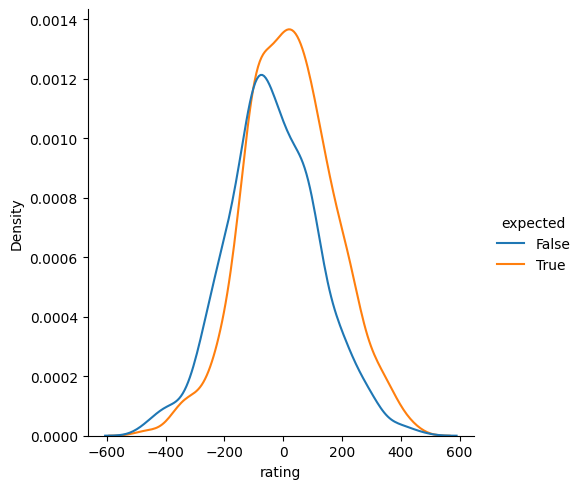

In [23]:
import seaborn as sbn

sbn.displot(data=reduced, x="rating", hue='expected', kind="kde")

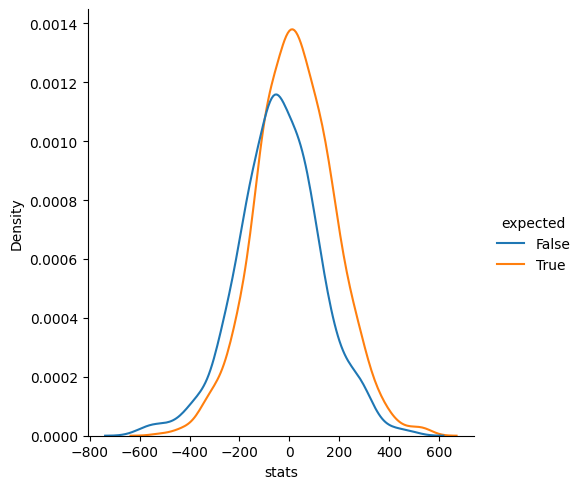

In [24]:
import seaborn as sbn

sbn.displot(data=reduced, x="stats", hue='expected', kind="kde")

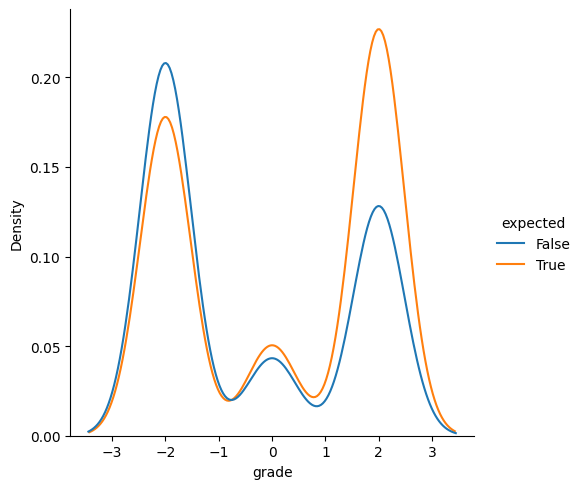

In [26]:
import seaborn as sbn

sbn.displot(data=reduced, x="grade", hue='expected', kind="kde")

In [ ]:
import seaborn as sbn

reduced['merge'] = reduced['stats'] + reduced['rating']

sbn.displot(data=reduced, x="grade", hue='expected', kind="kde")

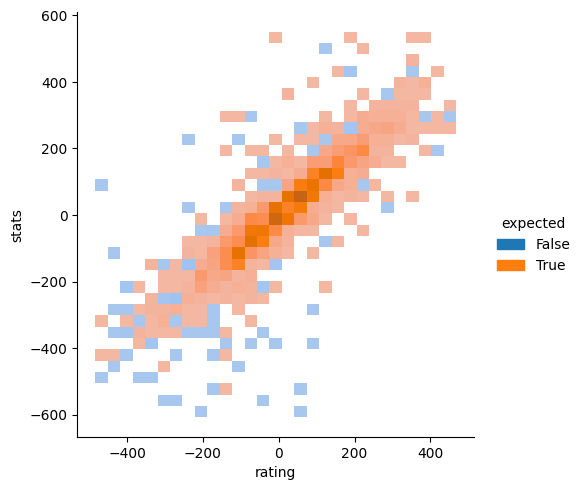

In [25]:
import seaborn as sbn

sbn.displot(data=reduced, x="rating", y="stats", hue='expected')

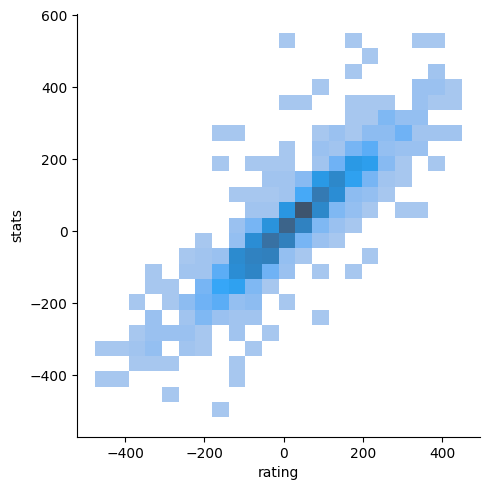

In [21]:
import seaborn as sbn

sbn.displot(data=reduced[reduced['expected'] == True], x="rating", y="stats")

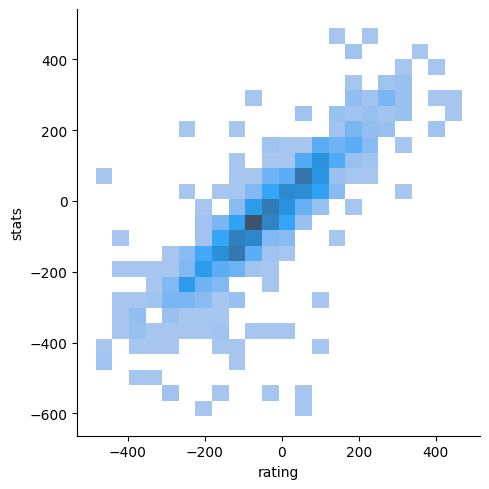

In [22]:
import seaborn as sbn

sbn.displot(data=reduced[reduced['expected'] == False], x="rating", y="stats")

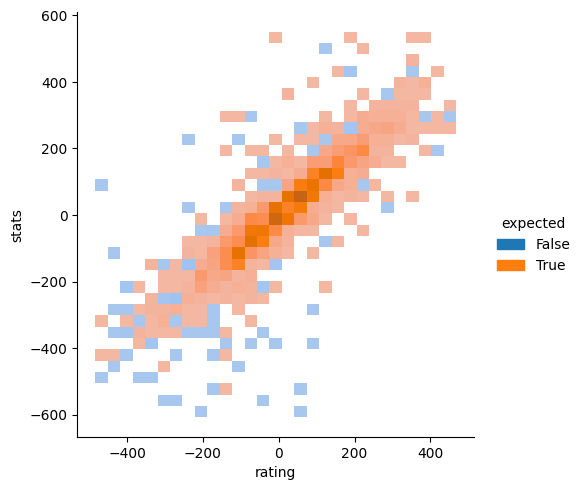

In [20]:
import seaborn as sbn

sbn.displot(data=reduced, x="rating", y="stats", hue='expected')